# Veamos como seleccionar el valor de `k` de K-Medias con *Silhouette Analysis*

No podemos utilizar **BIC**, o **MDL**, o **AIC**, porque no usamos un modelo de verosimilitud para ajustar.
Pero si podemos comparar entre diferentes modelos en función de **k** el valor de la inercia del modelo, esto es, la suma de distancias cuadradas dentro de cada cluster de la partición final.

La inercia se considera una medida de cuán coherentes los clusters son, por lo cual si se hace un gráfico de la inercia en función del **k**, se considera heurísticamente que el mejor valor se da cuando se desacelera la reducción de la inercia.
Lo cual es llamado *método del codo*.

Otra forma es considerar el **coeficiente de silueta**, que tiene valor entre $-1$ y $+1$.
Los coeficientes `s(i)` cercanos a $+1$ indican que la muestra está lejos de los clusters vecinos.
El valor $0$ indica que la muestra está muy cerca del borde de decisión entre los clusters.
Un valor negativo indica que esos puntos deben haber sido asignados al cluster equivocado.

El gráfico de esos coeficientes muestra también el balance de los clusters.
Si un cluster tiene muchos datos con respecto a otro que tiene muy pocos datos, o cuyos valores son menores al valor medio de los coeficientes, indican que ese agrupamiento no es bueno.

En los siguientes gráficos se ven los agrupamientos para **k** desde 2 a 6, y el gráfico de la inercia.
Tanto el coeficiente medio de silueta como la inercia marcan el **k ideal** como 4, el cual es el verdadero agrupamiento.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.cm import nipy_spectral
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1) # For reproducibility

Para n_clusters: 2, el silhouette_score promedio es: 0.7049787496083262
Para n_clusters: 3, el silhouette_score promedio es: 0.5882004012129721
Para n_clusters: 4, el silhouette_score promedio es: 0.6505186632729437
Para n_clusters: 5, el silhouette_score promedio es: 0.56376469026194
Para n_clusters: 6, el silhouette_score promedio es: 0.4504666294372765


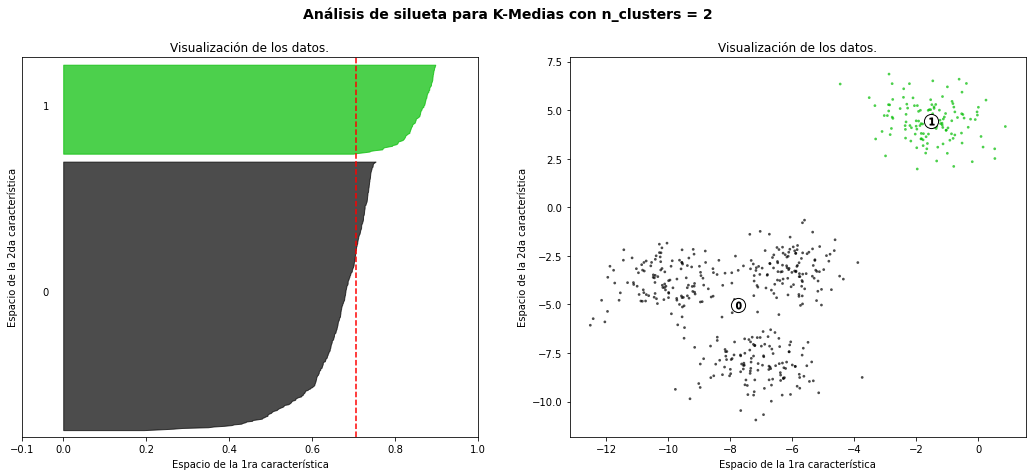

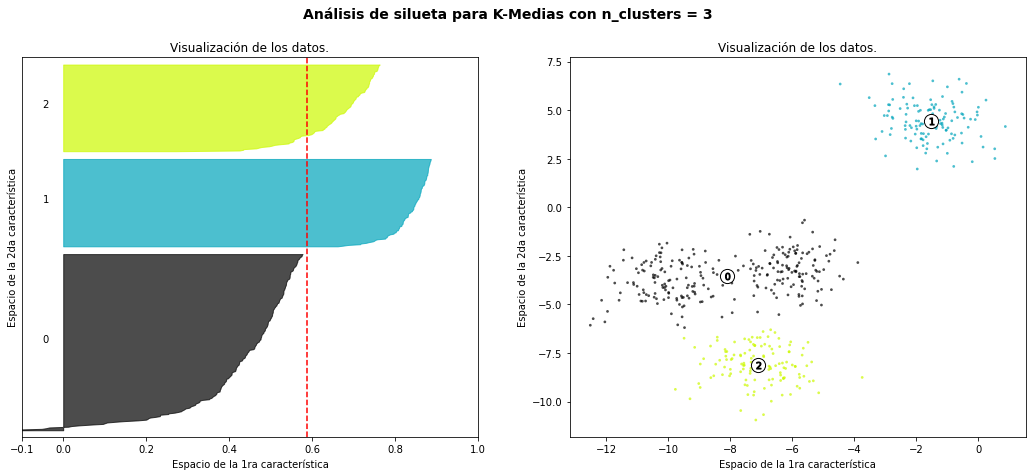

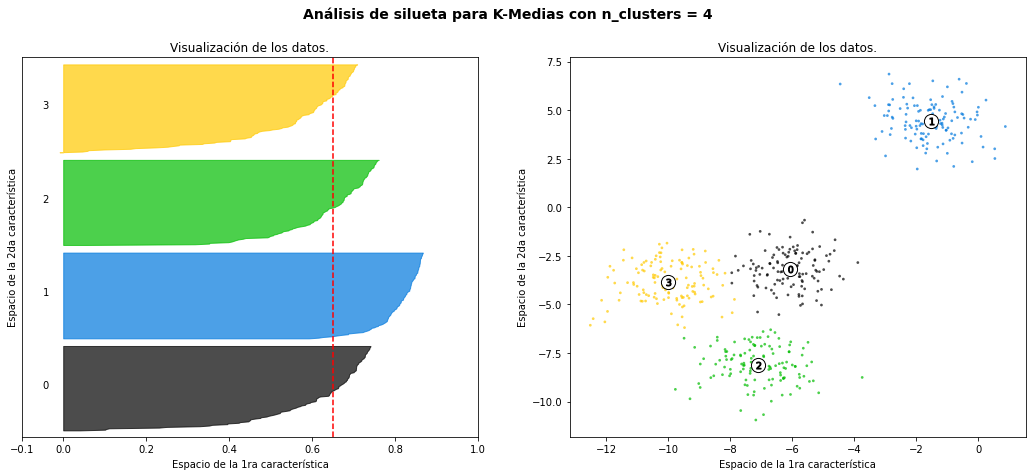

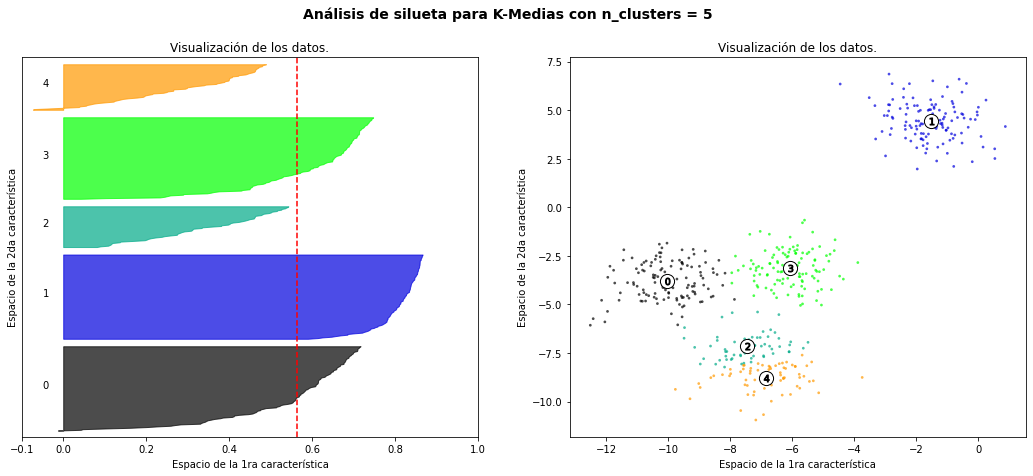

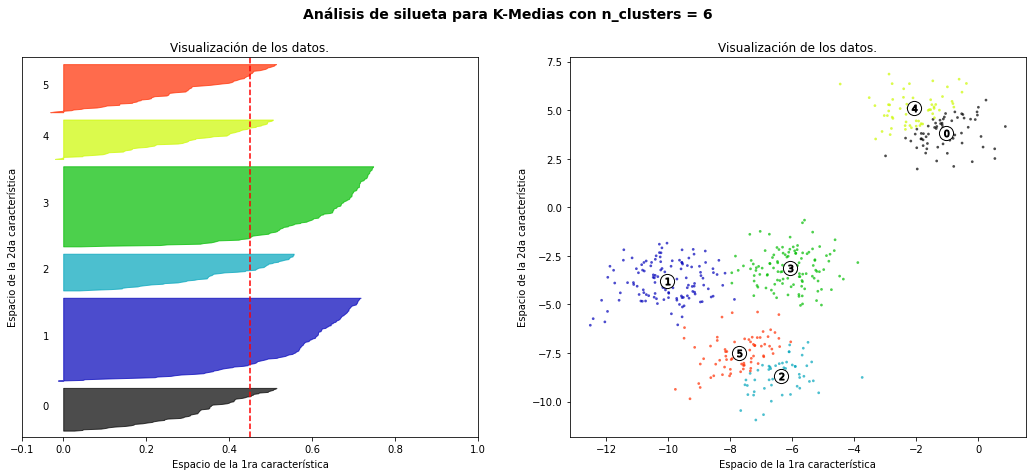

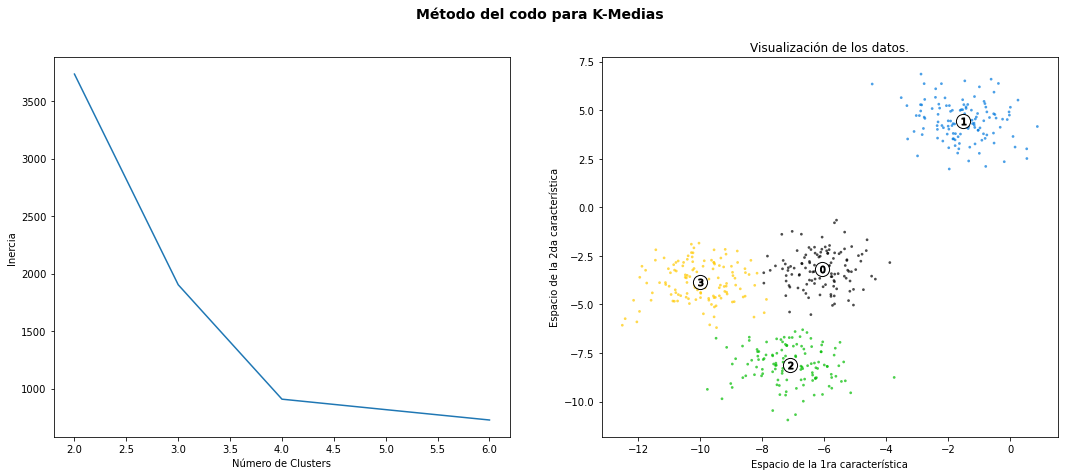

In [3]:
sse = {}
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters + 1) * 10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    sse[n_clusters] = clusterer.inertia_

    # The silhouette_score gives the average value for all the samples
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f'Para n_clusters: {n_clusters}, el silhouette_score promedio es: {silhouette_avg}')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]

        y_upper = y_lower + size_cluster_i

        color = nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0,
                          ith_cluster_silhouette_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10 # 10 for the 0 samples

    ax1.set_title('Visualización de los datos.')
    ax1.set_xlabel('Espacio de la 1ra característica')
    ax1.set_ylabel('Espacio de la 2da característica')

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax1.set_yticks([]) # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # The 2nd subplot showing the actual clusters formed
    colors = nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c='white', alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title('Visualización de los datos.')
    ax2.set_xlabel('Espacio de la 1ra característica')
    ax2.set_ylabel('Espacio de la 2da característica')

    plt.suptitle((f'Análisis de silueta para K-Medias con n_clusters = {n_clusters}'), fontsize=14, fontweight='bold')

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

plt.suptitle(('Método del codo para K-Medias'), fontsize=14, fontweight='bold')
ax1.plot(list(sse.keys()), list(sse.values()))
ax1.set_xlabel('Número de Clusters')
ax1.set_ylabel('Inercia')

clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(X)
    
colors = nipy_spectral(cluster_labels.astype(float) / 4)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c='white', alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

ax2.set_title('Visualización de los datos.')
ax2.set_xlabel('Espacio de la 1ra característica')
ax2.set_ylabel('Espacio de la 2da característica')

plt.show()